# Invasive Species Monitoring and the power of transfer learning

The goal of this notebook is to classify images of invasive plant species.

The data for this competition can be found [here](https://www.kaggle.com/c/invasive-species-monitoring).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. 
To get the data: <br>
`kaggle competitions download -c invasive-species-monitoring -p .` <br>

In [3]:
PATH = Path("/data2/yinterian/invasive-species-monitoring/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/model.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/__MACOSX'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/mode_tmp.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_303_227'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/sample_submission.csv.zip'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv.zip')]

In [4]:
list((PATH/"train").iterdir())[:10] 

[PosixPath('/data2/yinterian/invasive-species-monitoring/train/2249.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/92.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/302.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/2031.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1903.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1605.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/352.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/654.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1261.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/388.jpg')]

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

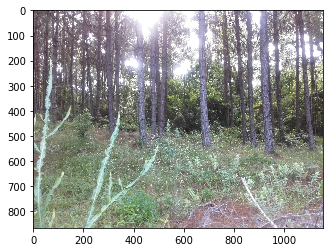

In [6]:
path = PATH/"train/2249.jpg"
im = read_image(path)
plt.imshow(im)

In [7]:
im = cv2.imread(str(path))
im.shape

(866, 1154, 3)

In [8]:
# let's look at the typical size of these images
path = PATH/"train"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]

In [9]:
np.unique(dims)

array([   3,  866, 1154])

Amazing! all images have the same size.

In [10]:
866/3.8, 1154/3.8

(227.89473684210526, 303.6842105263158)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [11]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

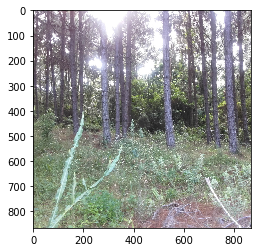

In [12]:
path = PATH/"train/2249.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

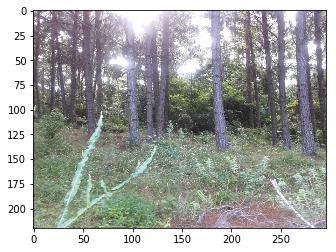

In [13]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (303, 227))
im2 = random_crop(im, 220, 296)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

-1.1211899405500048


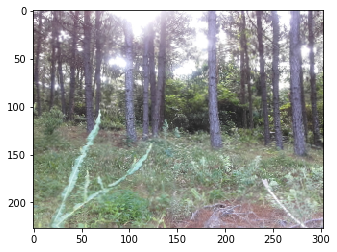

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

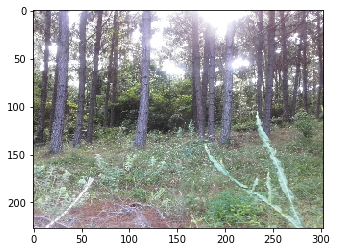

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [16]:
labels = pd.read_csv(PATH/"train_labels.csv")
labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [17]:
# how many classes
np.unique(labels.invasive.values)

array([0, 1])

In [18]:
# ration of 1 / total
labels.invasive.values.sum()/len(labels)

0.6309368191721133

In [19]:
np.random.seed(3)
mask = np.random.random(len(labels)) < 0.8
train_labels = labels[mask].copy()
valid_labels = labels[~mask].copy()

In [20]:
len(labels), len(train_labels), len(valid_labels) 

(2295, 1860, 435)

## Resizing data

In [21]:
def resize_crop_image(path, sz=(303, 227)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [22]:
def resize_all_images(resize_path, org_path):
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [23]:
# just run the first time
#resize_all_images(PATH/"train_303_227", PATH/"train")

## Dataset

In [24]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [25]:
def apply_transforms(x, sz=(303, 227), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = rotate_cv(x, np.random.uniform(-10,10))
    x = random_crop(x, sz[1], sz[0])
    if np.random.rand() >= .5:
                x = np.fliplr(x).copy()
    return x

In [26]:
class InvasiveDataset(Dataset):
    def __init__(self, files_path, labels, transform=False):
        self.num_files = len(labels)
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        row = self.labels.iloc[index,:]
        y = row["invasive"]
        file_name = str(row["name"]) + ".jpg"
        path = self.files_path/file_name
        x = read_image(path)
        if self.transform:
            x = apply_transforms(x)
        #else:
        #    x = cv2.resize(x, (303, 227))
        x = normalize(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [27]:
train_ds = InvasiveDataset(PATH/"train_303_227", labels=train_labels, transform=True)
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)

In [28]:
x, y = train_ds[0]
x.shape,y

((3, 227, 303), 0)

In [29]:
x, y = valid_ds[0]
x.shape,y

((3, 227, 303), 1)

In [30]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=64, num_workers=2)

In [31]:
len(train_ds)

1860

In [32]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [33]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [34]:
x.shape,y

((3, 227, 303), 0)

## Model

In [35]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [36]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [38]:
model = Net().cuda()

In [39]:
x, y = next(iter(train_dl))

In [40]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 227, 303])

In [41]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 8, 10])

In [42]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [43]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [44]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [45]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(1)).item()

0.7299438118934631

In [46]:
y

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

In [47]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def binary_loss(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
binary_loss(1, 0.5)

0.6931471805599453

In [48]:
# example
y = np.array([1, 1, 0])
y_logit = np.array([10, 1, -1])
sigmoid(y_logit)

array([0.9999546 , 0.73105858, 0.26894142])

In [49]:
l = [binary_loss(y1, p1) for y1,p1 in zip(y, sigmoid(y_logit))]
l

[4.539889921682063e-05, 0.3132616875182228, 0.3132616875182228]

In [50]:
np.mean(l)

0.20885625797855414

In [51]:
F.binary_cross_entropy_with_logits(torch.FloatTensor(y_logit), torch.FloatTensor(y))

tensor(0.2089)

In [52]:
# here we use sigmoid
F.binary_cross_entropy(torch.sigmoid(torch.FloatTensor(y_logit)), torch.FloatTensor(y))

tensor(0.2089)

## Learning rate finder

In [53]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [54]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=4):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [55]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.1)

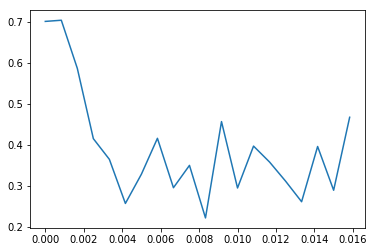

In [56]:
plt.plot(lrs[:20], losses[:20])
plt.show()

## Triangular learning rate training

In [57]:
def get_triangular_lr(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [58]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [59]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        out = model(x)
        pred = (out > 0.0).long()
        correct += pred.eq(y.data).sum().item()
        y = y.float()
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

## Training with triangular rates

In [60]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.01, epochs = 4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [61]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [62]:
model = Net().cuda()

In [63]:
val_metrics(model, valid_dl)

val loss and accuracy 2.745542803577993 0.632183908045977


In [64]:
training_loop(model, train_dl, valid_dl, steps=1, epochs = 8)

train loss 0.3939071858762413
val loss and accuracy 0.2800950512461279 0.8781609195402299
train loss 0.2589464326058665
val loss and accuracy 0.2875842765144918 0.8781609195402299
train loss 0.22548829845843776
val loss and accuracy 0.3636041290116036 0.8689655172413793
train loss 0.2129264667469968
val loss and accuracy 0.25877041871520295 0.8873563218390804
train loss 0.15605901871477404
val loss and accuracy 0.3372368552904019 0.8896551724137931
train loss 0.13588854472643586
val loss and accuracy 0.27857531528363283 0.9011494252873563
train loss 0.11972239315910364
val loss and accuracy 0.27754082193319823 0.9011494252873563
train loss 0.11032360741688359
val loss and accuracy 0.31694753807166526 0.9011494252873563
----End of step Time elapsed 0:02:10.799825


## Unfreezing layers

In [66]:
# save model
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [67]:
# load model
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [68]:
val_metrics(model, valid_dl)

val loss and accuracy 0.31694753807166526 0.9011494252873563


In [69]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [70]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [71]:
unfreeze(model, 7)
unfreeze(model, 6)

In [151]:
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=1e-3, epochs=2)

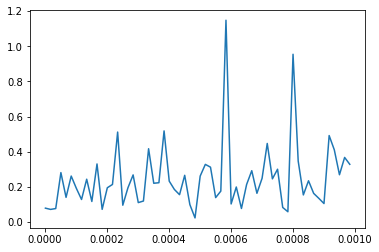

In [152]:
plt.plot(lrs[:100], losses[:100])
plt.show()

In [72]:
val_metrics(model, valid_dl)

val loss and accuracy 0.31694753807166526 0.9011494252873563


In [73]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.11565462863573464
val loss and accuracy 0.2396945332658702 0.9126436781609195
train loss 0.09413206769574073
val loss and accuracy 0.47513628684241194 0.8850574712643678
train loss 0.0570107321345037
val loss and accuracy 0.17666336604576002 0.9264367816091954
train loss 0.02463864280131235
val loss and accuracy 0.09644096116910035 0.9655172413793104


0.02463864280131235

In [74]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.025552435924289046
val loss and accuracy 0.7049994128873979 0.8183908045977012
train loss 0.04727138483931901
val loss and accuracy 0.19971797092892657 0.9379310344827586
train loss 0.024474786794794503
val loss and accuracy 0.09805659341743622 0.9586206896551724
train loss 0.009218814977074183
val loss and accuracy 0.09029708794992546 0.960919540229885


0.009218814977074183

In [75]:
p = PATH/"model.pth"
save_model(model, p)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions.

In [76]:
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)
valid_ds_trs = InvasiveDataset(PATH/"train_303_227", labels=valid_labels, transform=True)

In [78]:
# note that I am not shuffling the data loaders
batch_size = 64
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [79]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.unsqueeze(1).numpy())
    return np.vstack(preds), np.vstack(ys)

In [80]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [81]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

0.9770114942528736

## Lab
Can you get better accuracy?
* Unfreeze more layers
* Change some of the hyperparameters (dropout, number of the hidden units)
* Increase the image resolution


# References
This notebook is based on the implementation from fast.ai.